# LGBM을 활용한 베이스라인

In [1]:
import pandas as pd
import os
import random
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

## 1. 데이터 로딩

In [2]:
data_dir = '/opt/ml/project/data/' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'total_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path, parse_dates=['Timestamp']) 

## 2. Feature Engineering

In [3]:
def calculate_statistics(df):
    df['testType'] = df['testId'].apply(lambda x:x[:3])
    
    correct_i = df.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum'])
    correct_i.columns = ["item_mean", 'item_sum']
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']
    type_df = df.groupby('testType')['answerCode'].agg(['mean', 'count'])
    type_df.columns = ['type_mean', 'type_sum']
    
    df = pd.merge(df, correct_i, on=['assessmentItemID'], how="left")
    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    df = pd.merge(df, type_df, on=['testType'], how="left")
    
    return df

def calculate_cumulative_user_accuracy(df):
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    
    return df

def calculate_user_accuracy_trend(df, window_sizes=[5, 10, 30, 50, 100, 200]):
    user_accuracy_trend = [list() for _ in range(len(window_sizes))]

    for user_id, group_df in tqdm(df.groupby('userID')):
        num_corrects = group_df.answerCode.cumsum().shift(1)
        num_solved = np.arange(0,len(group_df))
        answer_rates = num_corrects / num_solved
        
        for i, window_size in enumerate(window_sizes):
            user_accuracy_trend[i].extend(answer_rates[:window_size])
            if window_size >= len(group_df):
                continue
            window = num_corrects[window_size:].values - num_corrects[:-window_size].values
            user_accuracy_trend[i].extend(window / window_size)

    for i, window_size in enumerate(window_sizes):
        df[f'user_accuracy_trend{window_size}'] = user_accuracy_trend[i]

    return df

def calculate_time(df):
    # 푼 시간대
    df['hour'] = df.Timestamp.dt.hour
    
    # 걸린 시간
    def calculate_elapsd_time(df, offset):
        elapsed_time = df.Timestamp.shift(-1) - df.Timestamp
        elapsed_time = elapsed_time.values / np.timedelta64(1, 's')
        time_cond1 = elapsed_time > 0
        time_cond2 = elapsed_time < offset
        elapsed_time[~(time_cond1 & time_cond2)] = elapsed_time[time_cond1 & time_cond2].mean()
        
        return elapsed_time
    
    for offset in [500,1000, 1500, 2000]:
        df[f'elapsedTime_{offset}'] = calculate_elapsd_time(df, offset=offset)
        temp_df1 = df[df['answerCode'] == 1].groupby('userID')[f'elapsedTime_{offset}'].agg(['mean'])
        temp_df1.columns = [f'user_mean_{offset}']
        df = pd.merge(df, temp_df1, on=['userID'], how="left")
        
        temp_df2 = df[df['answerCode'] == 1].groupby('assessmentItemID')[f'elapsedTime_{offset}'].agg(['mean'])
        temp_df2.columns = [f'question_mean_{offset}']
        df = pd.merge(df, temp_df2, on=['assessmentItemID'], how="left")
    
    return df

def feature_engineering(df):
    df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)
    df = calculate_statistics(df)
    df = calculate_cumulative_user_accuracy(df)
    df = calculate_user_accuracy_trend(df)
    df.fillna(0, inplace=True)
    
    df = calculate_time(df)
    return df

In [4]:
fe_df = feature_engineering(df)

KeyboardInterrupt: 

## 3. Train/Test 데이터 셋 분리

In [ ]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
def custom_train_test_split(df, user_ids=[], ratio=0.8, split=True):
    if len(user_ids) == 0 :
        users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
        random.seed(42)
        random.shuffle(users)
        
        max_train_data_len = ratio*len(df)
        sum_of_train_data = 0

        for user_id, count in users:
            sum_of_train_data += count
            if max_train_data_len < sum_of_train_data:
                break
            user_ids.append(user_id)
        
    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    train = pd.concat([train, test[test['userID'] == test['userID'].shift(-1)]])
    test = test[test['userID'] != test['userID'].shift(-1)]
    
    return train, test

In [ ]:
# DROP ANSWERCODE
test_df = fe_df[fe_df['answerCode'] == -1]
test_df = test_df.drop(['answerCode'], axis=1)
train_df = fe_df[fe_df['answerCode'] != -1]

In [ ]:
# 'elapsedTime', 'hour', 'item_mean', 'item_sum', 
# 'type_mean', 'type_sum'
# 'itemElapsedTime', 'prevMatchedNum', 'prevSolvedNum', 'elapsedTime2', 'elapsedTime3'

## 4. 훈련 및 검증

In [ ]:
# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean',
         'hour', 'type_mean',
         'user_accuracy_trend5', 'user_accuracy_trend10', 'user_accuracy_trend30', 
         'user_accuracy_trend50', 'user_accuracy_trend100', 'user_accuracy_trend200',
         'elapsedTime_500', 'elapsedTime_1000', 'elapsedTime_1500', 'elapsedTime_2000',
         'question_mean_500', 'question_mean_1000', 'question_mean_1500', 'question_mean_2000',
         'user_mean_500', 'user_mean_1000', 'user_mean_1500', 'user_mean_2000']

n_splits = 5
total_model = []
total_acc = []
total_auc = []

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for idx, (train_users, valid_users) in enumerate(kf.split(train_df.userID.unique())):
    np.save(f'cv/{n_splits}_splits_{idx}.npy', train_users)
    # 유저별 분리
    train, valid = custom_train_test_split(train_df, train_users)

    # X, y 값 분리
    y_train = train['answerCode']
    train = train.drop(['answerCode'], axis=1)

    y_valid = valid['answerCode']
    valid = valid.drop(['answerCode'], axis=1)

    lgb_train = lgb.Dataset(train[FEATS], y_train)
    lgb_valid = lgb.Dataset(valid[FEATS], y_valid)

    model = lgb.train(
        {'objective': 'binary',}, 
        lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        verbose_eval=100,
        num_boost_round=10000,
        early_stopping_rounds=100,
    )
    
    total_model.append(model)

    preds = model.predict(valid[FEATS])

    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    
    total_acc.append(acc)
    total_auc.append(auc)

    print(f'VALID AUC : {auc} ACC : {acc}\n')

print(f'TOTAL VALID AUC : {np.mean(total_auc)} ACC : {np.mean(total_acc)}\n')

[LightGBM] [Info] Number of positive: 1652889, number of negative: 871578
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6104
[LightGBM] [Info] Number of data points in the train set: 2524467, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654748 -> initscore=0.639975
[LightGBM] [Info] Start training from score 0.639975
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.495066	valid_1's binary_logloss: 0.567506
[200]	training's binary_logloss: 0.486885	valid_1's binary_logloss: 0.557465
[300]	training's binary_logloss: 0.481313	valid_1's binary_logloss: 0.550728
[400]	training's binary_logloss: 0.476806	valid_1's binary_logloss: 0.546116
[500]	training's binary_logloss: 0.47341	valid_1's binary_logloss:

KeyboardInterrupt: 

In [16]:
total_auc

[0.7344995563282084,
 0.7258795193764884,
 0.7287017632605869,
 0.7178088289579396,
 0.7569115009690202]

[0.7947031761421683, 0.7737380237380238, 0.7824131478317468]
[0.736181081098668, 0.7182507182507183, 0.7437826051582459]
[0.7951775592618749,
 0.7753427870390416,
 0.776094811388929,
 0.77755339862043,
 0.7910188452749414]

 [0.7344995563282084,
 0.7258795193764884,
 0.7287017632605869,
 0.7178088289579396,
 0.7569115009690202]

In [18]:
print(f'TOTAL VALID AUC : {np.mean(total_auc)} ACC : {np.mean(total_acc)}\n')

TOTAL VALID AUC : 0.785335323921743 ACC : 0.7121751370808849



TOTAL VALID AUC : 0.7565180726993144 ACC : 0.6780390777224508 (cv10*)

TOTAL VALID AUC : 0.757207809919822 ACC : 0.6905388973082196 (cv10)

TOTAL VALID AUC : 0.7570774704297358 ACC : 0.6905428797196059 (cv9*)

TOTAL VALID AUC : 0.7571095912583063 ACC : 0.6910804600842106 (cv9)

TOTAL VALID AUC : 0.7559525505259106 ACC : 0.6801882297910675 (cv8*)

TOTAL VALID AUC : 0.7568292373795549 ACC : 0.6714568136508453 (cv8)

TOTAL VALID AUC : 0.7568292373795549 ACC : 0.6714568136508453 (cv7*)

TOTAL VALID AUC : 0.7569712120786052 ACC : 0.6898676859464884 (cv7)

TOTAL VALID AUC : 0.7561004101113181 ACC : 0.6889237997452625 (cv6*)

TOTAL VALID AUC : 0.7575029648223891 ACC : 0.6891930501763234 (cv6)

TOTAL VALID AUC : 0.756430559358861 ACC : 0.6918821356615178 (cv5*)

TOTAL VALID AUC : 0.7572501963785683 ACC : 0.6912098218476714 (cv5)

TOTAL VALID AUC : 0.7562498785076734 ACC : 0.6891956717685601 (cv4*)

TOTAL VALID AUC : 0.7566441284059503 ACC : 0.6901364597597546 (cv4)

TOTAL VALID AUC : 0.7561189983680127 ACC : 0.6898682676513546 (cv3*)

TOTAL VALID AUC : 0.756763838418534 ACC : 0.6893307415930968 (cv3)

TOTAL VALID AUC : 0.785335323921743 ACC : 0.7121751370808849

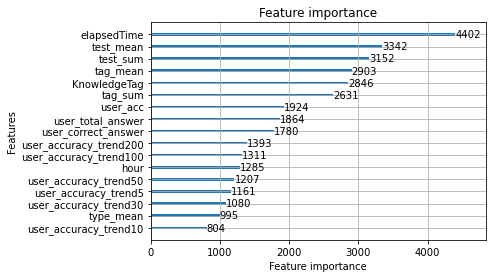

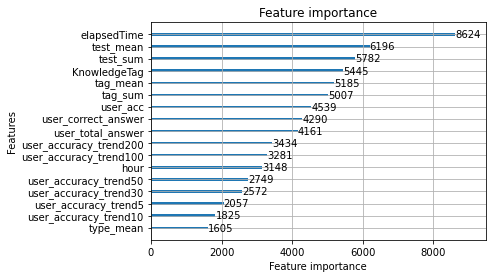

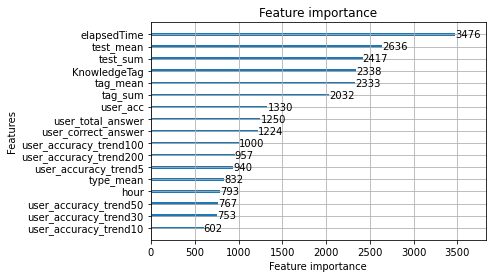

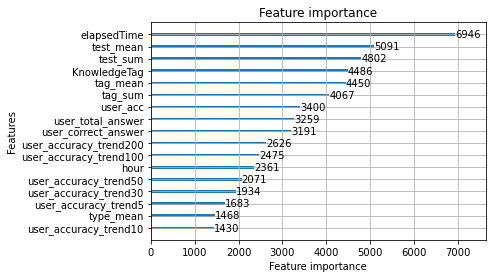

In [19]:
# INSTALL MATPLOTLIB IN ADVANCE
for model in total_model:
    _ = lgb.plot_importance(model, max_num_features=len(FEATS))

## 5. Inference

In [20]:
# MAKE PREDICTION
oof_pred = np.zeros(len(test_df[FEATS]))

for model in total_model:
    total_preds = model.predict(test_df[FEATS])
    oof_pred += total_preds / n_splits

In [21]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "kfold4.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(oof_pred):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/kfold4.csv
